mxsub = 8 mysub = 1 mz = 1024

nxpe = 128, nype = 1, npes = 128

Reading from 0: [0-9][0-0] -> [0-9][0-0]

Reading from 1: [2-9][0-0] -> [10-17][0-0]

Reading from 2: [2-9][0-0] -> [18-25][0-0]

Reading from 3: [2-9][0-0] -> [26-33][0-0]

Reading from 2: [2-9][0-0] -> [18-25][0-0]

Reading from 3: [2-9][0-0] -> [26-33][0-0]

Reading from 4: [2-9][0-0] -> [34-41][0-0]

Reading from 5: [2-9][0-0] -> [42-49][0-0]

Reading from 4: [2-9][0-0] -> [34-41][0-0]

Reading from 5: [2-9][0-0] -> [42-49][0-0]

Reading from 6: [2-9][0-0] -> [50-57][0-0]

Reading from 7: [2-9][0-0] -> [58-65][0-0]

Reading from 8: [2-9][0-0] -> [66-73][0-0]

Reading from 6: [2-9][0-0] -> [50-57][0-0]

Reading from 7: [2-9][0-0] -> [58-65][0-0]

Reading from 8: [2-9][0-0] -> [66-73][0-0]

Reading from 9: [2-9][0-0] -> [74-81][0-0]

Reading from 10: [2-9][0-0] -> [82-89][0-0]

Reading from 11: [2-9][0-0] -> [90-97][0-0]

Reading from 9: [2-9][0-0] -> [74-81][0-0]

Reading from 10: [2-9][0-0] -> [82-89][0-0]

Reading fr

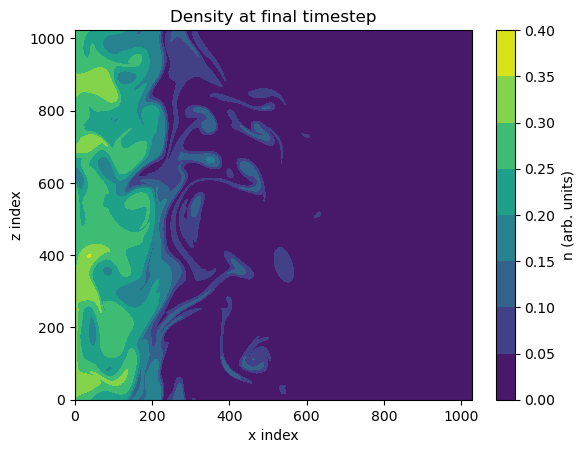

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 11 14:14:28 2024

@author: alec
"""

from pathlib import Path

from matplotlib import pyplot as plt
from boutdata import collect
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        epsilon = self.sample_epsilon()
        return self.mu + self.sigma * epsilon
            
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -0.5 * (math.log(2 * math.pi) + 2 * torch.log(self.sigma) + ((z - self.mu) ** 2) / (self.sigma ** 2))
# Absolute path to either the BOUT output directory or an individual BOUT.dmp file.
DATA_LOCATION = Path(
	r"C:\Users\kenne\OneDrive - Danmarks Tekniske Universitet\Deep Learning DTU\Data (1)\Data\Data_Files\BOUT.dmp.0.nc"
 )


def load_density(path_hint: Path):
	"""Return the density field collected from BOUT output files."""
	path_hint = path_hint.expanduser().resolve()

	# If the user points at a single file we only need the parent directory.
	bout_dir = path_hint.parent if path_hint.is_file() else path_hint

	density = collect("pe", path=str(bout_dir))
	return density.squeeze()


def plot_timestep(density,idx):
	"""Plot the density at the final time step."""
	fig, ax = plt.subplots()
	contour = ax.contourf(density[idx, :, :].T)
	fig.colorbar(contour, ax=ax, label="n (arb. units)")
	ax.set_title("Density at final timestep")
	ax.set_xlabel("x index")
	ax.set_ylabel("z index")
	plt.show()

#density_data = load_density(DATA_LOCATION)
#plot_timestep(density_data,-1)
density_data = torch.as_tensor(load_density(DATA_LOCATION), dtype=torch.float32)